##Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##1.0 Environment Setup

In [3]:
!apt-get install -y openslide-tools
!pip install openslide-python


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 41 not upgraded.
Need to get 104 kB of archives.
After this operation, 297 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libopenslide0 amd64 3.4.1+dfsg-5build1 [89.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 openslide-tools amd64 3.4.1+dfsg-5build1 [13.8 kB]
Fetched 104 kB in 0s (618 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 121229 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-5build1_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-5build1) ...
Selecting previously unselected package openslide-tools.

##2.0 Import and Configuration

In [4]:
# Complete configuration for your existing project structure
from pathlib import Path
import matplotlib.pyplot as plt
import os
import time
import json
import csv
import logging
import traceback
import openslide
from PIL import Image
import numpy as np
from tqdm import tqdm
import cv2
from skimage import morphology
from skimage.filters import threshold_sauvola
from concurrent.futures import ThreadPoolExecutor, as_completed

# Configure logging with more detailed format
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# === YOUR EXISTING PROJECT STRUCTURE ===
MAIN_PROJECT = Path("/content/drive/MyDrive/Colab Notebooks/WSI-MIL-Pipeline")
DATA_DIR = MAIN_PROJECT / "data"

# Data processing directories (within data/)
BASE = DATA_DIR
SLIDES_DIR = BASE / 'slides'
MASKS_DIR = BASE / 'masks'
PATCHES_DIR = BASE / 'patches_raw'
PATCHES_MASKED_DIR = BASE / 'patches_masked'
PATCHES_NORMALIZED_DIR = BASE / 'patches_normalized'
LOW_RES_DIR = BASE / 'low_resolution'
METADATA_DIR = BASE / 'metadata'
REPORTS_DIR = BASE / 'reports'

# Project directories (in main project)
MODELS_DIR = MAIN_PROJECT / 'models'
FEATURES_DIR = MAIN_PROJECT / 'features'
RESULTS_DIR = MAIN_PROJECT / 'results'
SCRIPTS_DIR = MAIN_PROJECT / 'scripts'

# Pipeline parameters
PATCH_SIZE = 256
STEP = 256
MASK_LEVEL = 6
MIN_MASK_OBJ = 100
MIN_TISSUE_FRAC = 0.05
MAX_WORKERS = 3

# NEW: Add normalization parameters
NORMALIZATION_METHOD = "histogram"  # Options: "macenko", "histogram", "simple"
QUALITY_CHECK = True
TARGET_PATCH_SAMPLES = 5

# Ensure all directories exist
all_dirs = [
    MAIN_PROJECT, DATA_DIR, SLIDES_DIR, MASKS_DIR, PATCHES_DIR,
    PATCHES_MASKED_DIR, PATCHES_NORMALIZED_DIR, LOW_RES_DIR,
    METADATA_DIR, REPORTS_DIR, MODELS_DIR, FEATURES_DIR,
    RESULTS_DIR, SCRIPTS_DIR
]

for directory in all_dirs:
    directory.mkdir(parents=True, exist_ok=True)

# NEW: Print directory structure for verification
def print_directory_structure():
    """Print the project structure for verification"""
    print("📁 Project Structure:")
    print(f"   Main Project: {MAIN_PROJECT}")
    print(f"   Data Directory: {DATA_DIR}")
    print("   Subdirectories:")
    for dir_path in all_dirs:
        if dir_path != MAIN_PROJECT and dir_path != DATA_DIR:
            status = "✅" if dir_path.exists() else "❌"
            print(f"     {status} {dir_path.relative_to(MAIN_PROJECT)}")

print_directory_structure()

logging.info(f"Using existing project: {MAIN_PROJECT}")
logging.info(f"Data directory: {DATA_DIR}")
logging.info(f"Using up to {MAX_WORKERS} workers for parallel tasks")
logging.info(f"Patch size: {PATCH_SIZE}, Step size: {STEP}")

📁 Project Structure:
   Main Project: /content/drive/MyDrive/Colab Notebooks/WSI-MIL-Pipeline
   Data Directory: /content/drive/MyDrive/Colab Notebooks/WSI-MIL-Pipeline/data
   Subdirectories:
     ✅ data/slides
     ✅ data/masks
     ✅ data/patches_raw
     ✅ data/patches_masked
     ✅ data/patches_normalized
     ✅ data/low_resolution
     ✅ data/metadata
     ✅ data/reports
     ✅ models
     ✅ features
     ✅ results
     ✅ scripts


##3.0 Utility Function

In [5]:
def pil_save(img, path):
    p = Path(path)
    p.parent.mkdir(parents=True, exist_ok=True)
    img.save(str(p))

def read_mask_bool(mask_path):
    arr = np.array(Image.open(mask_path).convert('L'))
    return arr > 0

def write_json(path, obj):
    p = Path(path)
    p.parent.mkdir(parents=True, exist_ok=True)
    with open(p, 'w') as f:
        json.dump(obj, f, indent=2)

def append_csv(path, row, header=None):
    p = Path(path)
    exists = p.exists()
    p.parent.mkdir(parents=True, exist_ok=True)
    with open(p, 'a', newline='') as f:
        writer = csv.writer(f)
        if not exists and header:
            writer.writerow(header)
        writer.writerow(row)

##4.0 Tissue Mask Generation

In [12]:
# FUNCTION: Adaptive Mask Generation for a Single Slide
def create_tissue_mask_adaptive(
    slide_path,
    mask_output_path,
    level=MASK_LEVEL,
    window_size=51,
    k=0.2,
    min_size=MIN_MASK_OBJ,
    min_tissue_coverage=0.01,
    max_tissue_coverage=0.95
):
    """Create tissue mask using Sauvola adaptive thresholding"""
    slide_path = Path(slide_path)
    mask_output_path = Path(mask_output_path)

    logging.info(f"Creating mask for {slide_path.name} at level {level}")

    try:
        # Input validation
        if not slide_path.exists():
            raise FileNotFoundError(f"Slide file not found: {slide_path}")

        # Ensure window_size is odd
        if window_size % 2 == 0:
            window_size += 1

        # Open slide
        slide = openslide.OpenSlide(str(slide_path))

        # Validate level exists
        if level >= slide.level_count:
            level = slide.level_count - 1
            logging.info(f"Requested level not available, using level {level} instead")

        lvl_dims = slide.level_dimensions[level]
        logging.info(f"Level dimensions: {lvl_dims}")

        # Read region
        pil_img = slide.read_region((0, 0), level, lvl_dims).convert('RGB')
        slide.close()

        # Convert to grayscale
        arr = np.array(pil_img)
        gray = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)

        # Adaptive thresholding
        mask = None
        method_used = "Sauvola"

        try:
            # Sauvola thresholding
            thresh = threshold_sauvola(gray, window_size=window_size, k=k)
            mask = gray > thresh
            tissue_coverage = mask.mean()
            logging.info(f"Sauvola thresholding - tissue coverage: {tissue_coverage:.3f}")

            # Polarity detection and inversion
            if tissue_coverage > max_tissue_coverage or tissue_coverage < min_tissue_coverage:
                mask = ~mask
                logging.info(f"Auto-inverted mask. New coverage: {mask.mean():.3f}")

        except Exception as e:
            logging.warning(f"Sauvola failed: {e}, falling back to Otsu thresholding")
            method_used = "Otsu"

            # Otsu fallback
            _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            mask = binary < 128
            tissue_coverage = mask.mean()

            if tissue_coverage > max_tissue_coverage or tissue_coverage < min_tissue_coverage:
                mask = ~mask
                logging.info(f"Otsu mask inverted. Final coverage: {mask.mean():.3f}")

        # Morphological cleaning
        try:
            pixel_count = mask.shape[0] * mask.shape[1]
            adaptive_min_size = max(min_size, int(pixel_count * 0.0001))

            mask = morphology.remove_small_objects(mask, min_size=adaptive_min_size)
            mask = morphology.remove_small_holes(mask, area_threshold=min_size)

            logging.info(f"Morphological cleaning completed. Final coverage: {mask.mean():.3f}")
        except Exception as e:
            logging.warning(f"Morphological operations failed: {e}. Using raw mask.")

        # Save mask
        mask_u8 = (mask.astype(np.uint8) * 255)
        pil_mask = Image.fromarray(mask_u8)
        mask_output_path.parent.mkdir(parents=True, exist_ok=True)
        pil_mask.save(mask_output_path)

        logging.info(f"✅ Mask saved to {mask_output_path} (method: {method_used}, coverage: {mask.mean():.3f})")

        return {
            'mask_array': mask,
            'mask_path': str(mask_output_path),
            'method_used': method_used,
            'tissue_coverage': float(mask.mean()),
            'level_used': level,
            'dimensions': mask.shape
        }

    except Exception as e:
        logging.error(f"Mask creation failed for {slide_path.name}: {e}")
        return None


# LOOP: Process all slides in folder
def process_all_slides(slides_dir=SLIDES_DIR, masks_dir=MASKS_DIR):
    slide_files = sorted(list(slides_dir.glob("*.svs"))) + sorted(list(slides_dir.glob("*.tif"))) + sorted(list(slides_dir.glob("*.ndpi")))

    if not slide_files:
        logging.warning(f"No slides found in {slides_dir}")
        return []

    results = []
    for slide_path in slide_files:
        mask_output_path = masks_dir / f"{slide_path.stem}_mask.png"
        result = create_tissue_mask_adaptive(slide_path, mask_output_path)
        if result:
            results.append(result)

    logging.info(f"🎯 Completed masking for {len(results)} slides.")
    return results


# EXECUTE
results = process_all_slides()
print(f"✅ {len(results)} masks generated.")


✅ 3 masks generated.


##5.0 Parallel Patch Extraction

In [13]:
def extract_patches_for_slide(slide_path, mask_path, out_dir,
                             max_patches=5000, skip_existing=True, show_visualization=True):
    """Extract tissue patches using mask"""
    slide_path = Path(slide_path)
    mask_path = Path(mask_path)
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    meta = {'slide': slide_path.name, 'start_time': time.time(),
            'saved_patches': 0, 'total_positions': 0, 'errors': []}

    try:
        slide = openslide.OpenSlide(str(slide_path))
        W, H = slide.level_dimensions[0]
        factor = slide.level_downsamples[MASK_LEVEL]

        # Load mask
        mask = np.array(Image.open(mask_path).convert("L")) > 128
        mask_h, mask_w = mask.shape

        total_positions, saved_patches = 0, 0
        for y in range(0, H - PATCH_SIZE + 1, STEP):
            for x in range(0, W - PATCH_SIZE + 1, STEP):
                if saved_patches >= max_patches:
                    break
                total_positions += 1

                mask_x, mask_y = int((x + PATCH_SIZE//2) / factor), int((y + PATCH_SIZE//2) / factor)
                if 0 <= mask_x < mask_w and 0 <= mask_y < mask_h and mask[mask_y, mask_x]:
                    out_path = out_dir / f"{slide_path.stem}_x{x}_y{y}.png"
                    if skip_existing and out_path.exists():
                        continue

                    patch = slide.read_region((x, y), 0, (PATCH_SIZE, PATCH_SIZE)).convert('RGB')
                    patch.save(out_path)
                    saved_patches += 1

        slide.close()
        meta.update({
            'saved_patches': saved_patches,
            'total_positions': total_positions,
            'runtime_sec': time.time() - meta['start_time']
        })

        print(f"✅ {slide_path.name}: {saved_patches}/{total_positions} patches saved")
        return meta

    except Exception as e:
        print(f"❌ Extraction failed for {slide_path.name}: {e}")
        meta['errors'].append(str(e))
        return meta


# ================================================================
# PARALLEL EXTRACTION ACROSS MULTIPLE SLIDES
# ================================================================
def extract_patches_parallel(max_workers=MAX_WORKERS, max_patches_per_slide=5000):
    slides = sorted(list(SLIDES_DIR.glob("*.svs"))) + sorted(list(SLIDES_DIR.glob("*.tif")))
    if not slides:
        print(f"❌ No slides found in {SLIDES_DIR}")
        return []

    print(f"🚀 Found {len(slides)} slides — extracting patches in parallel...")
    results, tasks = [], []
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        for slide_path in slides:
            mask_out = MASKS_DIR / f"{slide_path.stem}_mask_l{MASK_LEVEL}.png"
            if not mask_out.exists():
                create_tissue_mask_adaptive(slide_path, mask_out, level=MASK_LEVEL)

            out_dir = PATCHES_MASKED_DIR / slide_path.stem
            tasks.append(ex.submit(extract_patches_for_slide, slide_path, mask_out, out_dir, max_patches_per_slide))

        for fut in tqdm(as_completed(tasks), total=len(tasks), desc="Extracting patches"):
            res = fut.result()
            results.append(res)

    print(f"\n✅ Completed patch extraction for {len(results)} slides.")
    return results


# ================================================================
# DEBUG / STATUS CHECK
# ================================================================
def debug_patch_generation():
    print("🔧 DEBUG: Checking patch generation pipeline")
    slides = sorted(list(SLIDES_DIR.glob("*.svs"))) + sorted(list(SLIDES_DIR.glob("*.tif")))
    print(f"📁 Slides found: {len(slides)}")
    for s in slides:
        print(f"   - {s.name} ({'Exists' if s.exists() else 'Missing'})")

    masks = list(MASKS_DIR.glob("*.png"))
    print(f"🎭 Masks found: {len(masks)}")

    # Run full extraction for all slides
    if slides:
        results = extract_patches_parallel(max_workers=MAX_WORKERS, max_patches_per_slide=1000)
        total_patches = sum(r.get("saved_patches", 0) for r in results)
        print(f"\n🎯 TOTAL PATCHES GENERATED: {total_patches}")
        if total_patches > 0:
            print("✅ Patch generation successful!")
        else:
            print("❌ No patches extracted — check logs.")
    else:
        print("❌ No slides found to process.")


# ================================================================
# RUN DEBUG / EXTRACTION
# ================================================================
debug_patch_generation()

🔧 DEBUG: Checking patch generation pipeline
📁 Slides found: 3
   - test_001.tif (Exists)
   - test_002.tif (Exists)
   - test_003.tif (Exists)
🎭 Masks found: 3
🚀 Found 3 slides — extracting patches in parallel...


Extracting patches:  33%|███▎      | 1/3 [01:30<03:00, 90.27s/it]

✅ test_001.tif: 1000/1020 patches saved


Extracting patches: 100%|██████████| 3/3 [02:10<00:00, 43.57s/it]

✅ test_002.tif: 1000/119673 patches saved
✅ test_003.tif: 1000/138288 patches saved

✅ Completed patch extraction for 3 slides.

🎯 TOTAL PATCHES GENERATED: 3000
✅ Patch generation successful!


##6.0 Patch Normalization

Step 1: Running proper normalization...
🎯 PROPER PATCH NORMALIZATION
Source: /content/drive/MyDrive/Colab Notebooks/WSI-MIL-Pipeline/data/patches_masked
Target: /content/drive/MyDrive/Colab Notebooks/WSI-MIL-Pipeline/data/patches_normalized
Normalized patches before: 20

📁 Processing: test_001
   Found 1020 patches
   ✅ Progress: 10 total patches normalized
   ✅ Progress: 20 total patches normalized
   ✅ Progress: 30 total patches normalized
   ✅ Progress: 40 total patches normalized
   ✅ Progress: 50 total patches normalized
   ✅ Progress: 60 total patches normalized
   ✅ Progress: 70 total patches normalized
   ✅ Progress: 80 total patches normalized
   ✅ Progress: 90 total patches normalized
   ✅ Progress: 100 total patches normalized
   ✅ Progress: 110 total patches normalized
   ✅ Progress: 120 total patches normalized
   ✅ Progress: 130 total patches normalized
   ✅ Progress: 140 total patches normalized
   ✅ Progress: 150 total patches normalized
   ✅ Progress: 160 total patches

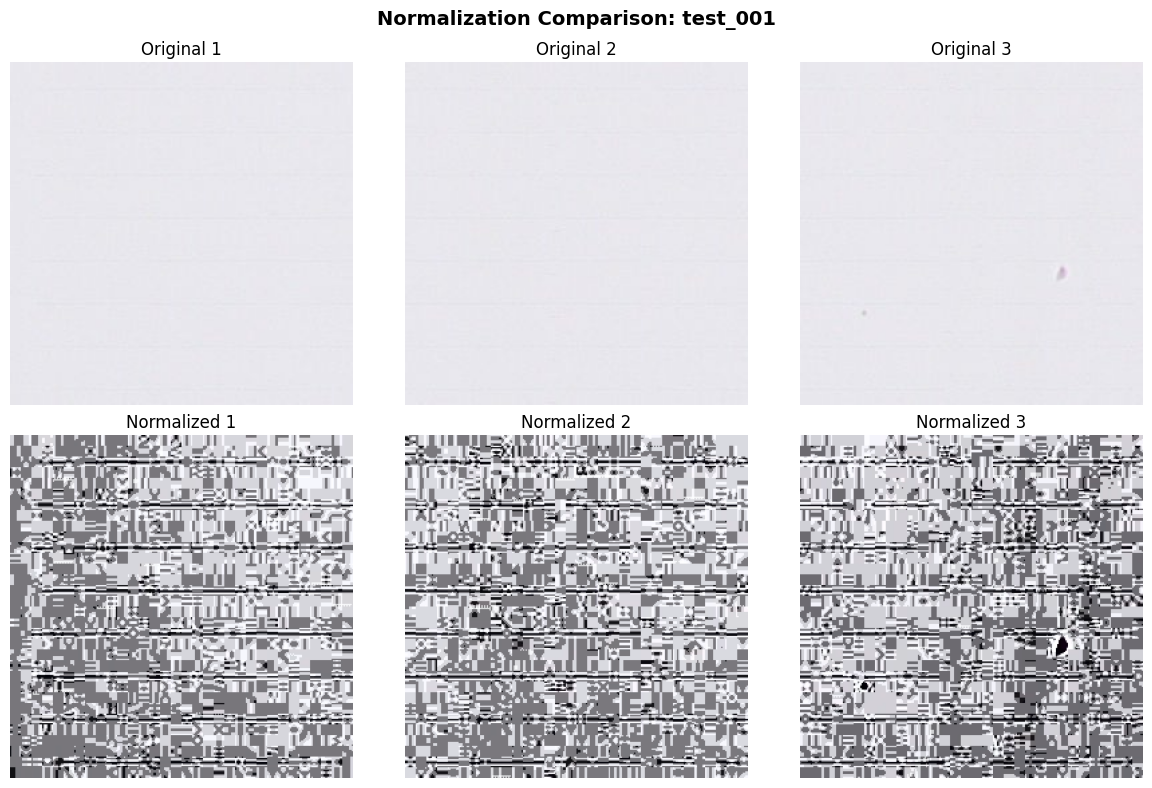

In [14]:
def normalize_all_patches_proper(patches_masked_dir, patches_normalized_dir, max_workers=MAX_WORKERS):
    """PROPER normalization based on proven working code"""

    print("🎯 PROPER PATCH NORMALIZATION")
    print("=" * 50)
    print(f"Source: {patches_masked_dir}")
    print(f"Target: {patches_normalized_dir}")

    # Count before
    normalized_before = count_normalized_patches()
    print(f"Normalized patches before: {normalized_before}")

    success_count = 0
    failure_count = 0
    skipped_count = 0

    # Process each slide
    for slide_dir in PATCHES_MASKED_DIR.iterdir():
        if not slide_dir.is_dir():
            continue

        slide_name = slide_dir.name
        print(f"\n📁 Processing: {slide_name}")

        # Create output directory
        output_dir = PATCHES_NORMALIZED_DIR / slide_name
        output_dir.mkdir(parents=True, exist_ok=True)

        patches = list(slide_dir.glob("*.png"))
        print(f"   Found {len(patches)} patches")

        slide_success = 0
        slide_failure = 0

        for patch_path in patches:
            try:
                output_path = output_dir / patch_path.name

                # Skip if already exists
                if output_path.exists():
                    skipped_count += 1
                    continue

                # Load and normalize using PROVEN method
                original = Image.open(patch_path).convert('RGB')
                src_array = np.array(original)

                # PROVEN: LAB histogram equalization
                lab = cv2.cvtColor(src_array, cv2.COLOR_RGB2LAB)
                l, a, b = cv2.split(lab)
                l_eq = cv2.equalizeHist(l)
                lab_eq = cv2.merge((l_eq, a, b))
                normalized_array = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2RGB)

                # Save
                normalized_img = Image.fromarray(normalized_array)
                normalized_img.save(output_path, quality=95)

                success_count += 1
                slide_success += 1

                # Print progress every 10 patches
                if success_count % 10 == 0:
                    print(f"   ✅ Progress: {success_count} total patches normalized")

            except Exception as e:
                print(f"   ❌ Failed {patch_path.name}: {e}")
                failure_count += 1
                slide_failure += 1

        print(f"   📊 Slide results: {slide_success} successful, {slide_failure} failed")

    # Count after
    normalized_after = count_normalized_patches()

    # Final summary
    print(f"\n🎉 NORMALIZATION COMPLETE")
    print("=" * 40)
    print(f"✅ Successful: {success_count} patches")
    print(f"❌ Failed: {failure_count} patches")
    print(f"⏭️  Skipped: {skipped_count} patches (already existed)")
    print(f"📈 Total normalized patches: {normalized_after}")
    print(f"📁 Location: {patches_normalized_dir}")

    return success_count

def count_normalized_patches():
    """Count all normalized patches"""
    total = 0
    for slide_dir in PATCHES_NORMALIZED_DIR.iterdir():
        if slide_dir.is_dir():
            patches = list(slide_dir.glob("*.png"))
            total += len(patches)
    return total

def quick_normalization_check():
    """Quick verification that normalization worked"""
    print("\n🔍 QUICK VERIFICATION")
    print("=" * 30)

    masked_count = sum(len(list(d.glob("*.png"))) for d in PATCHES_MASKED_DIR.iterdir() if d.is_dir())
    normalized_count = count_normalized_patches()

    print(f"Masked patches: {masked_count}")
    print(f"Normalized patches: {normalized_count}")

    if normalized_count > 0:
        completion = (normalized_count / masked_count) * 100 if masked_count > 0 else 0
        print(f"Completion: {completion:.1f}%")

        # Show sample of what was created
        for slide_dir in PATCHES_NORMALIZED_DIR.iterdir():
            if slide_dir.is_dir():
                patches = list(slide_dir.glob("*.png"))
                if patches:
                    print(f"\n📁 Sample from {slide_dir.name}:")
                    for i, patch in enumerate(patches[:2]):
                        print(f"   {i+1}. {patch.name}")
                    break
        return True
    else:
        print("❌ No normalized patches found")
        return False

def compare_normalization_quality():
    """Compare original vs normalized patches visually"""
    print("\n👀 VISUAL COMPARISON")
    print("=" * 30)

    # Find a slide with both types of patches
    for slide_dir in PATCHES_MASKED_DIR.iterdir():
        if slide_dir.is_dir():
            slide_name = slide_dir.name
            norm_dir = PATCHES_NORMALIZED_DIR / slide_name

            if norm_dir.exists():
                source_patches = list(slide_dir.glob("*.png"))
                norm_patches = list(norm_dir.glob("*.png"))

                if source_patches and norm_patches:
                    # Take first 3 pairs for comparison
                    comparison_pairs = min(3, len(source_patches), len(norm_patches))

                    fig, axes = plt.subplots(2, comparison_pairs, figsize=(4*comparison_pairs, 8))

                    for i in range(comparison_pairs):
                        # Original
                        orig_img = Image.open(source_patches[i])
                        axes[0, i].imshow(orig_img)
                        axes[0, i].set_title(f"Original {i+1}", fontsize=12)
                        axes[0, i].axis('off')

                        # Normalized
                        norm_img = Image.open(norm_dir / source_patches[i].name)
                        axes[1, i].imshow(norm_img)
                        axes[1, i].set_title(f"Normalized {i+1}", fontsize=12)
                        axes[1, i].axis('off')

                    plt.suptitle(f"Normalization Comparison: {slide_name}", fontsize=14, fontweight='bold')
                    plt.tight_layout()
                    plt.show()
                    break

# USAGE:
print("Step 1: Running proper normalization...")
success_count = normalize_all_patches_proper(PATCHES_MASKED_DIR, PATCHES_NORMALIZED_DIR)

print("\nStep 2: Quick verification...")
quick_normalization_check()

print("\nStep 3: Visual comparison...")
compare_normalization_quality()

##7.0 Metadata Consolidation and Thumbnail Generation

In [15]:
## 8.0 Enhanced Metadata Consolidation and Reporting

def consolidate_metadata_to_csv(metadata_dir=METADATA_DIR, out_csv=REPORTS_DIR / 'summary.csv'):
    """
    Enhanced metadata consolidation with comprehensive pipeline information
    """
    # Find all metadata files
    extraction_files = list(Path(metadata_dir).glob('*_extraction.json'))
    normalization_files = list(Path(metadata_dir).glob('*_normalization.json'))
    mask_files = list(Path(metadata_dir).glob('*_mask.json'))

    print(f"📊 Consolidating metadata from {len(extraction_files)} extraction files, "
          f"{len(normalization_files)} normalization files")

    # Enhanced header with comprehensive pipeline metrics
    header = [
        # Slide identification
        'slide_name', 'processing_date', 'pipeline_version',

        # Slide properties
        'slide_width', 'slide_height', 'level_count',

        # Mask information
        'mask_method', 'mask_level', 'mask_width', 'mask_height',
        'tissue_coverage', 'mask_creation_time',

        # Extraction metrics
        'total_positions', 'extracted_patches', 'extraction_success_rate',
        'extraction_errors', 'extraction_runtime', 'extraction_speed_pps',

        # Patch quality metrics
        'avg_patch_tissue_fraction', 'min_tissue_threshold',

        # Normalization metrics
        'normalized_patches', 'normalization_success_rate',
        'normalization_errors', 'normalization_runtime',
        'normalization_method', 'target_patch_contrast',

        # Overall pipeline metrics
        'total_runtime', 'overall_success_rate', 'pipeline_status',

        # File paths
        'slide_path', 'mask_path', 'extracted_patches_dir', 'normalized_patches_dir',

        # System information
        'workers_used', 'patch_size', 'step_size'
    ]

    out_csv.parent.mkdir(parents=True, exist_ok=True)

    consolidated_data = []

    for ext_file in extraction_files:
        try:
            slide_name = ext_file.stem.replace('_extraction', '')
            print(f"📝 Processing: {slide_name}")

            # Load extraction metadata
            with open(ext_file) as f:
                ext_data = json.load(f)

            # Load normalization metadata if exists
            norm_file = metadata_dir / f"{slide_name}_normalization.json"
            norm_data = {}
            if norm_file.exists():
                with open(norm_file) as f:
                    norm_data = json.load(f)

            # Load mask metadata if exists
            mask_file = metadata_dir / f"{slide_name}_mask.json"
            mask_data = {}
            if mask_file.exists():
                with open(mask_file) as f:
                    mask_data = json.load(f)

            # Calculate derived metrics
            extraction_success_rate = (ext_data.get('saved_patches', 0) / ext_data.get('total_positions', 1)) * 100
            extraction_speed = ext_data.get('saved_patches', 0) / ext_data.get('runtime_sec', 1) if ext_data.get('runtime_sec', 0) > 0 else 0

            normalization_success_rate = norm_data.get('success_rate', 0) if norm_data else 0
            total_runtime = ext_data.get('runtime_sec', 0) + norm_data.get('runtime_sec', 0)

            # Determine pipeline status
            if norm_data and norm_data.get('normalized_patches', 0) > 0:
                pipeline_status = "COMPLETE"
            elif ext_data.get('saved_patches', 0) > 0:
                pipeline_status = "EXTRACTED_ONLY"
            else:
                pipeline_status = "FAILED"

            # Build consolidated row
            row = [
                # Slide identification
                slide_name,
                ext_data.get('completion_time', 'Unknown'),
                '1.0',  # pipeline_version

                # Slide properties (placeholder - would need slide metadata)
                'Unknown', 'Unknown', 'Unknown',

                # Mask information
                mask_data.get('method_used', 'Unknown'),
                mask_data.get('level_used', MASK_LEVEL),
                mask_data.get('dimensions', ['Unknown'])[1] if 'dimensions' in mask_data else 'Unknown',
                mask_data.get('dimensions', ['Unknown'])[0] if 'dimensions' in mask_data else 'Unknown',
                mask_data.get('tissue_coverage', ext_data.get('tissue_coverage_frac', 0)),
                mask_data.get('completion_time', 'Unknown'),

                # Extraction metrics
                ext_data.get('total_positions', 0),
                ext_data.get('saved_patches', 0),
                extraction_success_rate,
                len(ext_data.get('errors', [])),
                ext_data.get('runtime_sec', 0),
                extraction_speed,

                # Patch quality metrics
                ext_data.get('avg_tissue_fraction', MIN_TISSUE_FRAC),
                MIN_TISSUE_FRAC,

                # Normalization metrics
                norm_data.get('normalized_patches', 0),
                normalization_success_rate,
                len(norm_data.get('errors', [])),
                norm_data.get('runtime_sec', 0),
                norm_data.get('method_used', 'LAB_Histogram'),
                norm_data.get('target_contrast', 0),

                # Overall pipeline metrics
                total_runtime,
                (extraction_success_rate + normalization_success_rate) / 2 if normalization_success_rate > 0 else extraction_success_rate,
                pipeline_status,

                # File paths
                f"slides/{slide_name}.tif",
                f"masks/{slide_name}_mask_l{MASK_LEVEL}.png",
                f"patches_masked/{slide_name}",
                f"patches_normalized/{slide_name}",

                # System information
                MAX_WORKERS,
                PATCH_SIZE,
                STEP
            ]

            consolidated_data.append(row)

        except Exception as e:
            print(f"❌ Error processing {ext_file.name}: {e}")
            continue

    # Write to CSV
    with open(out_csv, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(header)
        writer.writerows(consolidated_data)

    print(f"✅ Consolidated metadata for {len(consolidated_data)} slides")
    print(f"💾 Saved to: {out_csv}")

    # Generate summary report
    generate_summary_report(consolidated_data, header, out_csv)

    return len(consolidated_data)

def generate_summary_report(data, header, csv_path):
    """Generate a visual summary report from consolidated data"""
    if not data:
        print("❌ No data available for summary report")
        return

    print(f"\n📈 GENERATING SUMMARY REPORT")
    print("=" * 50)

    # Convert to DataFrame for easier analysis
    df_data = []
    for row in data:
        df_data.append(dict(zip(header, row)))

    # Calculate overall statistics
    total_slides = len(data)
    total_extracted = sum(row[header.index('extracted_patches')] for row in data)
    total_normalized = sum(row[header.index('normalized_patches')] for row in data)
    avg_extraction_rate = np.mean([row[header.index('extraction_success_rate')] for row in data])
    avg_normalization_rate = np.mean([row[header.index('normalization_success_rate')] for row in data if row[header.index('normalization_success_rate')] > 0])

    complete_pipelines = sum(1 for row in data if row[header.index('pipeline_status')] == 'COMPLETE')

    print(f"📊 PIPELINE SUMMARY:")
    print(f"   Total Slides Processed: {total_slides}")
    print(f"   Complete Pipelines: {complete_pipelines} ({complete_pipelines/total_slides*100:.1f}%)")
    print(f"   Total Patches Extracted: {total_extracted}")
    print(f"   Total Patches Normalized: {total_normalized}")
    print(f"   Average Extraction Success: {avg_extraction_rate:.1f}%")
    print(f"   Average Normalization Success: {avg_normalization_rate:.1f}%")

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Success rates distribution
    extraction_rates = [row[header.index('extraction_success_rate')] for row in data]
    axes[0, 0].hist(extraction_rates, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_xlabel('Extraction Success Rate (%)')
    axes[0, 0].set_ylabel('Number of Slides')
    axes[0, 0].set_title('Extraction Success Rate Distribution', fontweight='bold')
    axes[0, 0].axvline(np.mean(extraction_rates), color='red', linestyle='--', label=f'Mean: {np.mean(extraction_rates):.1f}%')
    axes[0, 0].legend()

    # Patches per slide
    patches_per_slide = [row[header.index('extracted_patches')] for row in data]
    axes[0, 1].hist(patches_per_slide, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0, 1].set_xlabel('Patches per Slide')
    axes[0, 1].set_ylabel('Number of Slides')
    axes[0, 1].set_title('Patches Distribution per Slide', fontweight='bold')
    axes[0, 1].axvline(np.mean(patches_per_slide), color='red', linestyle='--', label=f'Mean: {np.mean(patches_per_slide):.1f}')
    axes[0, 1].legend()

    # Pipeline status
    status_counts = {}
    for row in data:
        status = row[header.index('pipeline_status')]
        status_counts[status] = status_counts.get(status, 0) + 1

    axes[1, 0].pie(status_counts.values(), labels=status_counts.keys(), autopct='%1.1f%%',
                   colors=['#2ecc71', '#f39c12', '#e74c3c'])
    axes[1, 0].set_title('Pipeline Completion Status', fontweight='bold')

    # Tissue coverage vs extraction success
    tissue_coverage = [row[header.index('tissue_coverage')] for row in data]
    axes[1, 1].scatter(tissue_coverage, extraction_rates, alpha=0.6, color='purple')
    axes[1, 1].set_xlabel('Tissue Coverage Fraction')
    axes[1, 1].set_ylabel('Extraction Success Rate (%)')
    axes[1, 1].set_title('Tissue Coverage vs Extraction Success', fontweight='bold')

    # Add correlation coefficient
    correlation = np.corrcoef(tissue_coverage, extraction_rates)[0,1]
    axes[1, 1].text(0.05, 0.95, f'Correlation: {correlation:.3f}',
                   transform=axes[1, 1].transAxes, fontsize=12,
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.suptitle('WSI Pipeline Analysis Report', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / 'pipeline_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"💾 Summary report saved to: {REPORTS_DIR / 'pipeline_summary.png'}")

def create_lowres_thumbnails(slides_dir=SLIDES_DIR, out_dir=LOW_RES_DIR, level=MASK_LEVEL,
                           overlay_masks=False, quality=85):
    """
    Enhanced thumbnail creation with optional mask overlays
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    slides = [p for p in Path(slides_dir).iterdir() if p.is_file() and p.suffix.lower() in ['.tif', '.tiff', '.svs', '.ndpi']]

    print(f"🖼️  Creating thumbnails for {len(slides)} slides")

    success_count = 0
    for s in tqdm(slides, desc="Creating thumbnails"):
        try:
            slide = openslide.OpenSlide(str(s))
            lvl = min(level, slide.level_count - 1)

            # Get low resolution image
            lvl_dims = slide.level_dimensions[lvl]
            img = slide.read_region((0, 0), lvl, lvl_dims).convert('RGB')

            # Resize for consistent thumbnail size
            max_thumb_size = (1024, 1024)
            img.thumbnail(max_thumb_size, Image.Resampling.LANCZOS)

            # Add mask overlay if requested
            if overlay_masks:
                mask_path = MASKS_DIR / f"{s.stem}_mask_l{level}.png"
                if mask_path.exists():
                    mask = Image.open(mask_path).convert('L')
                    mask = mask.resize(img.size, Image.Resampling.NEAREST)

                    # Create overlay (red mask on original)
                    overlay = Image.new('RGB', img.size, (255, 0, 0))
                    mask_array = np.array(mask)
                    overlay_array = np.array(overlay)
                    img_array = np.array(img)

                    # Apply mask overlay where tissue is detected
                    tissue_mask = mask_array > 0
                    for channel in range(3):
                        img_array[:,:,channel] = np.where(
                            tissue_mask,
                            np.minimum(img_array[:,:,channel] * 0.7 + overlay_array[:,:,channel] * 0.3, 255),
                            img_array[:,:,channel]
                        )

                    img = Image.fromarray(img_array.astype(np.uint8))

            # Save thumbnail
            img.save(out_dir / f"{s.stem}_lowres.jpg", quality=quality, optimize=True)
            slide.close()
            success_count += 1

        except Exception as e:
            logging.error(f'Failed to create thumbnail for {s.name}: {e}')
            continue

    print(f"✅ Created {success_count}/{len(slides)} thumbnails")
    return success_count

def generate_pipeline_report():
    """
    Generate a comprehensive pipeline report with all metadata
    """
    print("📋 GENERATING COMPREHENSIVE PIPELINE REPORT")
    print("=" * 60)

    # Consolidate metadata first
    csv_path = REPORTS_DIR / 'pipeline_summary.csv'
    slide_count = consolidate_metadata_to_csv(out_csv=csv_path)

    if slide_count == 0:
        print("❌ No data available for report generation")
        return

    # Create thumbnails
    print("\n🖼️  Generating thumbnails...")
    thumbnail_count = create_lowres_thumbnails(overlay_masks=True)

    # Generate HTML report
    html_report = REPORTS_DIR / 'pipeline_report.html'
    generate_html_report(csv_path, html_report, thumbnail_count)

    print(f"\n🎉 PIPELINE REPORT COMPLETE")
    print(f"📊 Slides processed: {slide_count}")
    print(f"🖼️  Thumbnails created: {thumbnail_count}")
    print(f"📄 CSV report: {csv_path}")
    print(f"🌐 HTML report: {html_report}")
    print(f"📈 Summary plot: {REPORTS_DIR / 'pipeline_summary.png'}")

# Usage
def quick_metadata_status():
    """Quick status check for metadata"""
    print("📊 METADATA STATUS")
    print("=" * 30)

    extraction_files = list(METADATA_DIR.glob('*_extraction.json'))
    normalization_files = list(METADATA_DIR.glob('*_normalization.json'))

    print(f"📁 Extraction metadata: {len(extraction_files)} files")
    print(f"🎨 Normalization metadata: {len(normalization_files)} files")

    if extraction_files:
        total_patches = 0
        for f in extraction_files:
            with open(f) as json_file:
                data = json.load(json_file)
                total_patches += data.get('saved_patches', 0)
        print(f"📦 Total patches in metadata: {total_patches}")

    return len(extraction_files) > 0

##8.0 Quality Control Visualization

In [16]:
# Quality Control Visualization

def qc_visualize_slide(slide_id, n_patches=9):
    raw = Path(PATCHES_DIR) / slide_id
    masked = Path(PATCHES_MASKED_DIR) / slide_id
    norm = Path(PATCHES_NORMALIZED_DIR) / slide_id

    fig, axes = plt.subplots(3, n_patches, figsize=(3 * n_patches, 9))

    for i, d in enumerate([raw, masked, norm]):
        files = sorted(d.glob('*.png')) if d.exists() else []
        files = files[:n_patches]

        for j in range(n_patches):
            ax = axes[i, j]
            if j < len(files):
                try:
                    ax.imshow(Image.open(files[j]))
                except Exception as e:
                    ax.text(0.5, 0.5, f"Error\n{files[j].name}",
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_facecolor('lightcoral')
            else:
                ax.text(0.5, 0.5, "No patch",
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_facecolor('lightgray')
            ax.axis('off')

    # Add row labels
    row_labels = ['Raw Patches', 'Tissue Patches', 'Normalized Patches']
    for i, label in enumerate(row_labels):
        axes[i, 0].figure.text(0.02, 0.85 - i*0.33, label,
                              rotation=90, va='center', ha='center',
                              fontsize=12, fontweight='bold')

    plt.suptitle(f'Quality Control: {slide_id}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

##9.0 Full Pipeline Orchestration

In [17]:
# Full Pipeline Orchestration

def run_full_pipeline(colab_workers=MAX_WORKERS):
    """Run the complete WSI processing pipeline"""

    # Find all WSI files
    slides = sorted([
        p for p in Path(SLIDES_DIR).iterdir()
        if p.is_file() and p.suffix.lower() in ('.svs', '.tif', '.tiff', '.ndpi')
    ])

    if not slides:
        logging.warning("No WSI files found to process!")
        return []

    logging.info(f"Starting pipeline for {len(slides)} slides")

    # STEP 1: Create masks in parallel
    logging.info("Step 1: Creating tissue masks...")
    with ThreadPoolExecutor(max_workers=colab_workers) as ex:
        futures = {}
        for s in slides:
            mask_out = MASKS_DIR / f"{s.stem}_mask_l{MASK_LEVEL}.png"
            if mask_out.exists():
                continue
            futures[ex.submit(create_tissue_mask_adaptive, s, mask_out)] = s

        # Process mask creation with progress bar
        for fut in tqdm(as_completed(futures), total=len(futures), desc="Creating masks"):
            try:
                fut.result()
            except Exception:
                logging.exception('Masking task failed')

    # STEP 2: Extract patches
    logging.info("Step 2: Extracting tissue patches...")
    extraction_meta = extract_patches_parallel(slides, max_workers=colab_workers, mask_level=MASK_LEVEL)

    # STEP 3: Normalize patches
    logging.info("Step 3: Normalizing patches...")
    normalize_all_patches(PATCHES_MASKED_DIR, PATCHES_NORMALIZED_DIR, max_workers=colab_workers)

    # STEP 4: Consolidate metadata
    logging.info("Step 4: Consolidating metadata...")
    consolidate_metadata_to_csv()

    # STEP 5: Create thumbnails
    logging.info("Step 5: Creating thumbnails...")
    create_lowres_thumbnails()

    # Summary
    total_patches = sum(meta.get('saved_patches', 0) for meta in extraction_meta)
    logging.info(f"Pipeline completed! Processed {len(extraction_meta)} slides, extracted {total_patches} patches")

    return extraction_meta

# To run: uncomment
# run_full_pipeline()